In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from regression import PCovR, KPCovR, SparseKPCovR
from regression import KRR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.kernel_ridge import KernelRidge

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


In [3]:
# sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
# sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/analysis/scripts')
# from utilities.sklearn_covr.kpcovr import KernelPCovR as KPCovR2
# from utilities.sklearn_covr.pcovr import PCovR as PCovR2
# from helpers import l_regr, l_kpcovr

# Functions

In [4]:
def df_to_class(df, df_type, n_classes, use_df_sums=True):
    """
        Make class predictions based on a decision function.
        Based on the sci-kit learn SVC prediction, see
        `sklearn.multiclass._ovr_decision_function` 
        (sci-kit learn licensed under BSD 3-Clause license)
        
        ---Arguments---
        df: decision function on which to make class predictions
        df_type: decision function type, 'ovo' or 'ovr'
        n_classes: number of integer classes
        use_df_sums: augment the 'ovo' vote counts with
            decision function values (useful for tie breaks)
            
        ---Returns---
        predicted_class: predicted integer class
    """
    
    # Approximation to the number of classes, should be valid up to at least 1M
    #n_classes = int(np.sqrt(2*df.shape[-1])) + 1
    
    if df_type == 'ovo':
        vote_matrix = np.zeros((df.shape[0], n_classes))
        df_sum = np.zeros((df.shape[0], n_classes))

        # Predicted class determined by majority vote
        col_idx = 0
        for i in range(0, n_classes):
            for j in range(i + 1, n_classes):
                col_train = df[:, col_idx]
                vote_matrix[col_train > 0, i] += 1
                vote_matrix[col_train <= 0, j] += 1

                # Add value of decision function
                if use_df_sums:
                    df_sum[:, i] += df[:, col_idx]
                    df_sum[:, j] -= df[:, col_idx]

                col_idx += 1

        # sci-kit learn transformation from 'ovo' to 'ovr'
        if use_df_sums:
            transformed_df_sum = df_sum / (3 * (np.abs(df_sum) + 1))
            vote_matrix += transformed_df_sum

        predicted_class = np.argmax(vote_matrix, axis=1) + 1

    elif df_type == 'ovr':

        # Predicted class determined by largest value of the decision function
        predicted_class = np.argmax(df, axis=1) + 1
        
    else:
        print("Error: invalid decision function. Use 'ovo' or 'ovr'")
        
    return predicted_class

# Load and split data

In [5]:
# Load train and test set indices for Deem
idxs_deem_train = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
idxs_deem_test = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

# Total number of structures
n_deem_train = idxs_deem_train.size
n_deem_test = idxs_deem_test.size
n_deem = n_deem_train + n_deem_test

In [6]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [7]:
# Load IZA cantons
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]
cantons_iza = np.delete(cantons_iza, RWY)
n_iza = len(cantons_iza)

In [8]:
# Select IZA sample
# (will be overwritten if we load a kernel
n_iza_train = n_iza // 2
n_iza_test = n_iza - n_iza_train
idxs_iza = np.arange(0, n_iza)
np.random.shuffle(idxs_iza)

idxs_iza_train = idxs_iza[0:n_iza_train]
idxs_iza_test = idxs_iza[n_iza_train:n_iza_train+n_iza_test]

In [9]:
# Make dummy DEEM cantons
cantons_deem = np.ones(n_deem, dtype=int) * 4

# Load SOAPs and build kernels

In [10]:
# Flag to recompute existing kernels
remove_kernels = False

In [11]:
K_train = {}
K_test = {}
K_test_test = {}
kernel_type = {}
gamma = {}

In [12]:
for cutoff in cutoffs:
    kernel_file = f'../Processed_Data/Models/{cutoff}/structure_kernels.hdf5'
    
    # Start fresh
    if remove_kernels and os.path.exists(kernel_file):
        os.remove(kernel_file)
    
    # Load the kernels if they exist
    try:
        f = h5py.File(kernel_file, 'r')
        
        K_train[cutoff] = f['K_train'][:]
        K_test[cutoff] = f['K_test'][:]
        K_test_test[cutoff] = f['K_test_test'][:]
        kernel_type[cutoff] = f.attrs['kernel_type']
        gamma[cutoff] = f.attrs['gamma']
        
        # Don't need to store indices in a dictonary
        # since they are the same for all cutoffs
        idxs_iza_train = f.attrs['idxs_iza_train']
        idxs_iza_test = f.attrs['idxs_iza_test']
        idxs_deem_train = f.attrs['idxs_deem_train']
        idxs_deem_test = f.attrs['idxs_deem_test']
 
        f.close()
    
    # Compute the kernels if they don't exist
    except OSError:
    
        # Load kernel parameters
        model_file = f'../Processed_Data/Models/{cutoff}/volumes_mae_parameters.json'

        with open(model_file, 'r') as f:
            model_dict = json.load(f)

        kernel_type[cutoff] = model_dict['kernel_type']
        gamma[cutoff] = model_dict['gamma']

        # Load SOAPs
        deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
        deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)

        iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
        iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
        iza_soaps.pop(RWY)

        # Build the collection of soap vectors
        # for the "master" kernel
        deem_train = [deem_soaps[i] for i in idxs_deem_train]
        deem_test = [deem_soaps[i] for i in idxs_deem_test]
        iza_train = [iza_soaps[i] for i in idxs_iza_train]
        iza_test = [iza_soaps[i] for i in idxs_iza_test]

        # Build "master" kernel between all DEEM and all IZA
        K_train[cutoff] = build_kernel(iza_train+deem_train, iza_train+deem_train, 
                                       kernel=kernel_type[cutoff], gamma=gamma[cutoff])
        K_test[cutoff] = build_kernel(iza_test+deem_test, iza_train+deem_train, 
                                      kernel=kernel_type[cutoff], gamma=gamma[cutoff])
        K_test_test[cutoff] = build_kernel(iza_test+deem_test, iza_test+deem_test, 
                                           kernel=kernel_type[cutoff], gamma=gamma[cutoff])
        
        # Save kernels for later
        g = h5py.File(kernel_file, 'w')
        
        g.create_dataset('K_train', data=K_train[cutoff])
        g.create_dataset('K_test', data=K_test[cutoff])
        g.create_dataset('K_test_test', data=K_test_test[cutoff])
        
        g.attrs['idxs_iza_train'] = idxs_iza_train
        g.attrs['idxs_iza_test'] = idxs_iza_test
        g.attrs['idxs_deem_train'] = idxs_deem_train
        g.attrs['idxs_deem_test'] = idxs_deem_test
        g.attrs['kernel_type'] = kernel_type[cutoff]
        g.attrs['gamma'] = gamma[cutoff]
        
        g.close()

In [13]:
# Save IZA indices for later
# (we do this after the kernel loading to make sure that if an existing
# kernel is loaded, the associated indices don't get overwritten)
#np.savetxt(f'../Processed_Data/IZA_226onDEEM_10k/train.idxs', idxs_iza_train, fmt='%d')
#np.savetxt(f'../Processed_Data/IZA_226onDEEM_10k/test.idxs', idxs_iza_test, fmt='%d')

In [14]:
# Build set of "master" canton labels
cantons_train = np.concatenate((cantons_iza[idxs_iza_train], cantons_deem[idxs_deem_train]))
cantons_test = np.concatenate((cantons_iza[idxs_iza_test], cantons_deem[idxs_deem_test]))
n_classes = np.amax(cantons_train)

In [15]:
# Center and scale kernels
for cutoff in cutoffs:
    K_test[cutoff] = center_kernel_fast(K_test[cutoff], K_ref=K_train[cutoff])
    K_train[cutoff] = center_kernel_fast(K_train[cutoff])

    K_scale = np.trace(K_train[cutoff]) / K_train[cutoff].shape[0]
    K_test[cutoff] /= K_scale
    K_train[cutoff] /= K_scale

# SVM on full test and train sets

In [76]:
for cutoff in cutoffs:
    
    model_dir = f'../Processed_Data/Models/{cutoff}'
    with open(f'{model_dir}/ksvc_parameters.json', 'r') as f:
        model_dict = json.load(f)
            
    # Assemble kernels
    k_train = K_train[cutoff]
    k_test = K_test[cutoff]

    # SVC
    svc = SVC(kernel='precomputed', decision_function_shape=model_dict['df_type'], 
              class_weight=model_dict['class_weight'], C=model_dict['C'])
    svc.fit(k_train, cantons_train)
    
    df_train = svc.decision_function(k_train) 
    df_test = svc.decision_function(k_test)
    
    predicted_cantons_train = svc.predict(k_train)
    predicted_cantons_test = svc.predict(k_test)
    
    # Save decision functions
    df_deem = np.zeros((n_deem, df_train.shape[1]))
    df_deem[idxs_deem_train] = df_train[n_iza_train:]
    df_deem[idxs_deem_test] = df_test[n_iza_test:]
    np.savetxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/ksvc_structure_dfs.dat', df_deem)
    
    df_iza = np.zeros((n_iza, df_train.shape[1]))
    df_iza[idxs_iza_train] = df_train[0:n_iza_train]
    df_iza[idxs_iza_test] = df_test[0:n_iza_test]
    np.savetxt(f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/ksvc_structure_dfs.dat', df_iza)
    
    # Save KSVC class predictions
    predicted_cantons_deem = np.zeros(n_deem)
    predicted_cantons_deem[idxs_deem_train] = predicted_cantons_train[n_iza_train:]
    predicted_cantons_deem[idxs_deem_test] = predicted_cantons_test[n_iza_test:]
    np.savetxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/ksvc_structure_cantons.dat',
               predicted_cantons_deem, fmt='%d')
    
    predicted_cantons_iza = np.zeros(n_iza)
    predicted_cantons_iza[idxs_iza_train] = predicted_cantons_train[0:n_iza_train]
    predicted_cantons_iza[idxs_iza_test] = predicted_cantons_test[0:n_iza_test]
    np.savetxt(f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/ksvc_structure_cantons.dat', 
               predicted_cantons_iza, fmt='%d')
    
    # Classification stats
    print(svc.score(k_train, cantons_train))
    print(svc.score(k_test, cantons_test))
    print(svc.class_weight_)
    print(classification_report(cantons_train, predicted_cantons_train))
    print(classification_report(cantons_test, predicted_cantons_test))
    print(confusion_matrix(cantons_train, predicted_cantons_train))
    print(confusion_matrix(cantons_test, predicted_cantons_test))

0.9922411600101755
0.9631823952602624
[1. 1. 1. 1.]
              precision    recall  f1-score   support

           1       0.83      0.48      0.61        21
           2       0.70      0.56      0.62        54
           3       1.00      0.41      0.58        37
           4       0.99      1.00      1.00      7750

    accuracy                           0.99      7862
   macro avg       0.88      0.61      0.70      7862
weighted avg       0.99      0.99      0.99      7862

              precision    recall  f1-score   support

           1       0.29      0.14      0.19        14
           2       0.67      0.41      0.51        68
           3       0.30      0.10      0.15        31
           4       0.97      1.00      0.99      2250

    accuracy                           0.96      2363
   macro avg       0.56      0.41      0.46      2363
weighted avg       0.95      0.96      0.96      2363

[[  10    2    0    9]
 [   2   30    0   22]
 [   0    7   15   15]
 [   0   

# Check that decision functions can be predicted with KRR

In [18]:
for cutoff in cutoffs:
    
    # Assemble kernels
    k_train = K_train[cutoff]
    k_test = K_test[cutoff]
    
    # Load decision functions
    df_deem = np.loadtxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/ksvc_structure_dfs.dat')
    df_iza = np.loadtxt(f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/ksvc_structure_dfs.dat')
    
    df_deem_train = df_deem[idxs_deem_train]
    df_deem_test = df_deem[idxs_deem_test]
    
    df_iza_train = df_iza[idxs_iza_train]
    df_iza_test = df_iza[idxs_iza_test]
    
    df_train = np.concatenate((df_iza_train, df_deem_train))
    df_test = np.concatenate((df_iza_test, df_deem_test))
    
    # Center and scale decision functions
    df_center = np.mean(df_train, axis=0)
    df_train -= df_center
    df_test -= df_center

    df_scale = np.linalg.norm(df_train, axis=0) / np.sqrt(df_train.shape[0] / df_train.shape[1])
    df_train /= df_scale
    df_test /= df_scale

    # Test KRR on decision functions
    # NOTE: KRR can't predict the test set
    # decision function very well -- why?
    
#     krr = KernelRidge(alpha=1.0E-12, kernel='precomputed')
#     krr.fit(k_train, df_krr_train)
#     dfp_krr_train = krr.predict(k_train)
#     dfp_krr_test = krr.predict(k_test)

    krr = KRR(regularization=1.0E-12)
    krr.fit(k_train, df_train)
    dfp_train = krr.transform(k_train)
    dfp_test = krr.transform(k_test)
    
    print(np.mean(np.abs(dfp_train - df_train), axis=0))
    print(np.mean(np.abs(dfp_test - df_test), axis=0))

[2.19911738e-10 1.44524039e-10 2.90358797e-10 4.56533142e-10
 5.76625113e-10 7.50105517e-10]
[3.35264631e-08 2.31812654e-08 3.88996174e-08 7.78725327e-08
 9.17959789e-08 1.23009302e-07]
[6.58845468e-14 4.23329704e-14 1.75668462e-13 2.99769630e-13
 1.48984297e-13 3.46390672e-13]
[1.59052562e-13 8.00689082e-14 2.43869435e-13 6.98207929e-13
 3.44091663e-13 5.89233179e-13]


# KPCovR on full test and train sets

In [78]:
# Use a different number of components than that used for the optimization
n_components_override = 100

# Use an alpha other than the optimal
alpha_override = None

# Use a regularization other than the optimal
regularization_override = None

In [79]:
for cutoff in cutoffs:
    
    model_dir = f'../Processed_Data/Models/{cutoff}'
    with open(f'{model_dir}/kpcovr_parameters.json', 'r') as f:
        model_dict = json.load(f)
        
    with open(f'{model_dir}/ksvc_parameters.json', 'r') as f:
        df_type = json.load(f)['df_type']
        
    # Assemble kernels
    k_train = K_train[cutoff]
    k_test = K_test[cutoff]
        
    # Load decision functions
    df_deem = np.loadtxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/ksvc_structure_dfs.dat')
    df_iza = np.loadtxt(f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/ksvc_structure_dfs.dat')
    
    df_deem_train = df_deem[idxs_deem_train]
    df_deem_test = df_deem[idxs_deem_test]
    
    df_iza_train = df_iza[idxs_iza_train]
    df_iza_test = df_iza[idxs_iza_test]
    
    df_train = np.concatenate((df_iza_train, df_deem_train))
    df_test = np.concatenate((df_iza_test, df_deem_test))
    
    # Center and scale decision functions
    df_center = np.mean(df_train, axis=0)
    df_train -= df_center
    df_test -= df_center

    df_scale = np.linalg.norm(df_train, axis=0) / np.sqrt(df_train.shape[0] / df_train.shape[1])
    df_train /= df_scale
    df_test /= df_scale
    
    # Set KPCovR parameters
    if n_components_override is not None:
        n_components = n_components_override
    else:
        n_components = model_dict['n_components']
        
    if alpha_override is not None:
        alpha = alpha_override
    else:
        alpha = model_dict['alpha']
        
    if regularization_override is not None:
        regularization = regularization_override
    else:
        regularization = model_dict['regularization']

#     kpcovr = KPCovR2(n_components=n_components, kernel='precomputed',
#                      mixing=alpha,
#                      krr_params=dict(alpha=regularization))
#     kpcovr.fit(k_train, y_train)

#     T_train[cutoff] = kpcovr.transform(k_train)
#     yp_train[cutoff] = kpcovr.predict(k_train) 
#     T_test[cutoff] = kpcovr.transform(k_test) 
#     yp_test[cutoff] = kpcovr.predict(k_test)

    kpcovr = KPCovR(n_components=n_components, 
                    alpha=alpha, 
                    regularization=regularization)
    kpcovr.fit(k_train, df_train)
    
    T_train = kpcovr.transform_K(k_train)
    dfp_train = kpcovr.transform_Y(k_train)
    T_test = kpcovr.transform_K(k_test)
    dfp_test = kpcovr.transform_Y(k_test)
        
    # Save KPCovR projections
    n_digits_deem = len(str(n_deem - 1))
    T_deem = np.zeros((n_deem, n_components))
    T_deem[idxs_deem_train] = T_train[n_iza_train:]
    T_deem[idxs_deem_test] = T_test[n_iza_test:]
    
    g = h5py.File(f'../Processed_Data/DEEM_10k/Data/{cutoff}/kpcovr_structures.hdf5', 'w')
    for tdx, t in enumerate(T_deem):
        g.create_dataset(str(tdx).zfill(n_digits_deem), data=t)
        
    g.attrs['n_components'] = n_components
    g.attrs['alpha'] = alpha
    g.attrs['regularization'] = regularization
    
    g.close()
    
    n_digits_iza = len(str(n_iza - 1))
    T_iza = np.zeros((n_iza, n_components))
    T_iza[idxs_iza_train] = T_train[0:n_iza_train]
    T_iza[idxs_iza_test] = T_test[0:n_iza_test]
    
    g = h5py.File(f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/kpcovr_structures.hdf5', 'w')
    for tdx, t in enumerate(T_iza):
        g.create_dataset(str(tdx).zfill(n_digits_iza), data=t)
        
    g.attrs['n_components'] = n_components
    g.attrs['alpha'] = alpha
    g.attrs['regularization'] = regularization
        
    g.close()
                    
    # Pickle the models
    # Copy the dict so we can make the numpy arrays lists
    kpcovr_dict = kpcovr.__dict__.copy()

    # Convert arrays to lists
    for k, v in kpcovr_dict.items():
        if isinstance(v, np.ndarray):
            kpcovr_dict[k] = v.tolist()

    # Save
    with open(f'{model_dir}/kpcovr.json', 'w') as f:
        json.dump(kpcovr_dict, f)
    
    # Rescale to raw decision function
    dfp_train = dfp_train * df_scale + df_center
    dfp_test = dfp_test * df_scale + df_center

    # Predict classes based on KPCovRized decision functions
    predicted_cantons_train = df_to_class(dfp_train, df_type, n_classes, use_df_sums=True)
    predicted_cantons_test = df_to_class(dfp_test, df_type, n_classes, use_df_sums=True)
    
    # Save KPCovR decision function predictions
    if df_type == 'ovo':
        n_df = n_classes * (n_classes - 1) // 2
    else:
        n_df = n_classes
    
    df_deem = np.zeros((n_deem, n_df))
    df_deem[idxs_deem_train] = dfp_train[n_iza_train:]
    df_deem[idxs_deem_test] = dfp_test[n_iza_test:]
    np.savetxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/kpcovr_structure_dfs.dat', df_deem)
    
    df_iza = np.zeros((n_iza, n_df))
    df_iza[idxs_iza_train] = dfp_train[0:n_iza_train]
    df_iza[idxs_iza_test] = dfp_test[0:n_iza_test]
    np.savetxt(f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/kpcovr_structure_dfs.dat', df_iza)
    
    # Save KPCovR class predictions
    predicted_cantons_deem = np.zeros(n_deem)
    predicted_cantons_deem[idxs_deem_train] = predicted_cantons_train[n_iza_train:]
    predicted_cantons_deem[idxs_deem_test] = predicted_cantons_test[n_iza_test:]
    np.savetxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/kpcovr_structure_cantons.dat',
               predicted_cantons_deem, fmt='%d')
    
    predicted_cantons_iza = np.zeros(n_iza)
    predicted_cantons_iza[idxs_iza_train] = predicted_cantons_train[0:n_iza_train]
    predicted_cantons_iza[idxs_iza_test] = predicted_cantons_test[0:n_iza_test]
    np.savetxt(f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/kpcovr_structure_cantons.dat', 
               predicted_cantons_iza, fmt='%d')

    # Classification stats
    print(classification_report(cantons_train, predicted_cantons_train))
    print(classification_report(cantons_test, predicted_cantons_test))
    print(confusion_matrix(cantons_train, predicted_cantons_train))
    print(confusion_matrix(cantons_test, predicted_cantons_test))
    
    print(np.mean(np.abs(dfp_train - df_train), axis=0))
    print(np.mean(np.abs(dfp_test - df_test), axis=0))

              precision    recall  f1-score   support

           1       0.83      0.48      0.61        21
           2       0.73      0.56      0.63        54
           3       1.00      0.41      0.58        37
           4       0.99      1.00      1.00      7750

    accuracy                           0.99      7862
   macro avg       0.89      0.61      0.70      7862
weighted avg       0.99      0.99      0.99      7862

              precision    recall  f1-score   support

           1       0.33      0.14      0.20        14
           2       0.68      0.40      0.50        68
           3       0.36      0.13      0.19        31
           4       0.97      1.00      0.99      2250

    accuracy                           0.96      2363
   macro avg       0.59      0.42      0.47      2363
weighted avg       0.95      0.96      0.96      2363

[[  10    2    0    9]
 [   2   30    0   22]
 [   0    7   15   15]
 [   0    2    0 7748]]
[[   2    5    0    7]
 [   3   27   

# Plot (TODO: move to new analysis notebook)

In [80]:
# Load IZA cantons
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]
cantons_iza = np.delete(cantons_iza, RWY)
n_iza = len(cantons_iza)

In [81]:
# Make dummy DEEM cantons
cantons_deem = np.ones(n_deem, dtype=int) * 4

In [82]:
# Load train and test indices
idxs_deem_train = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
idxs_deem_test = np.loadtxt('../Processed_Data/DEEM_10k/test.idxs', dtype=int)

idxs_iza_train = np.loadtxt('../Processed_Data/IZA_226onDEEM_10k/train.idxs', dtype=int)
idxs_iza_test = np.loadtxt('../Processed_Data/IZA_226onDEEM_10k/test.idxs', dtype=int)

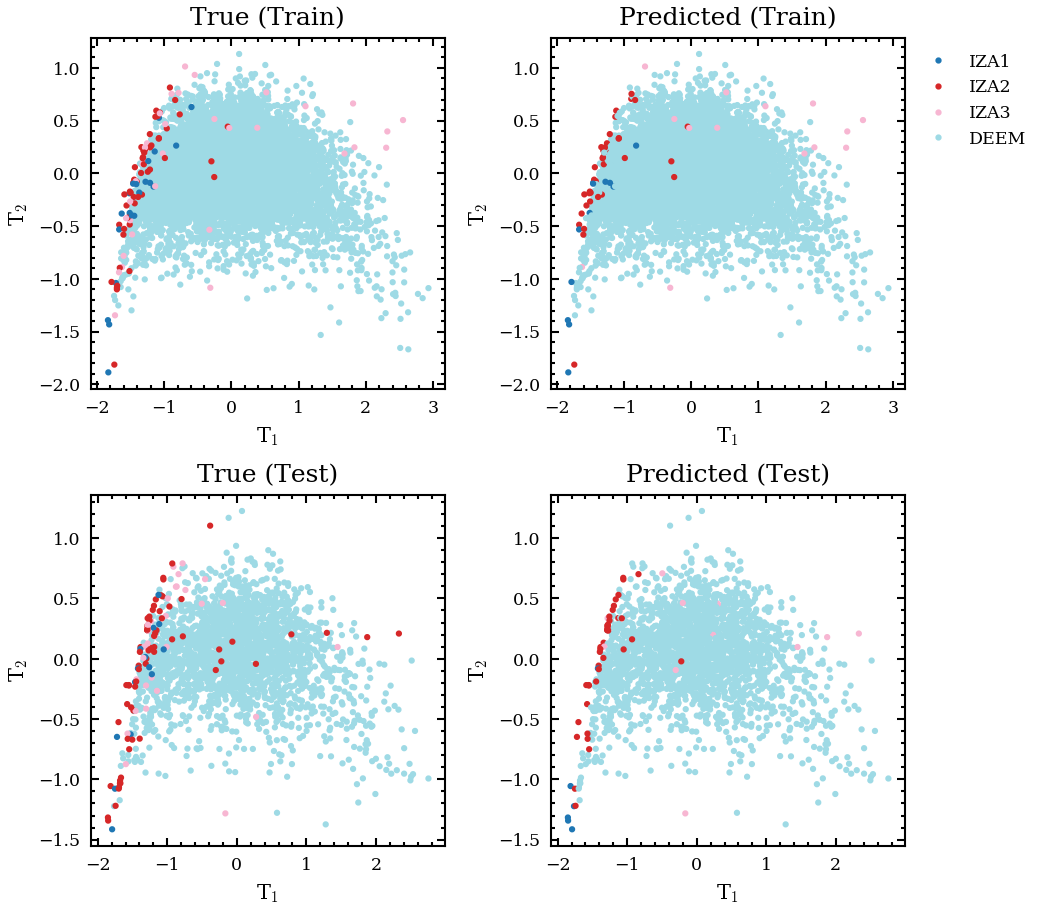

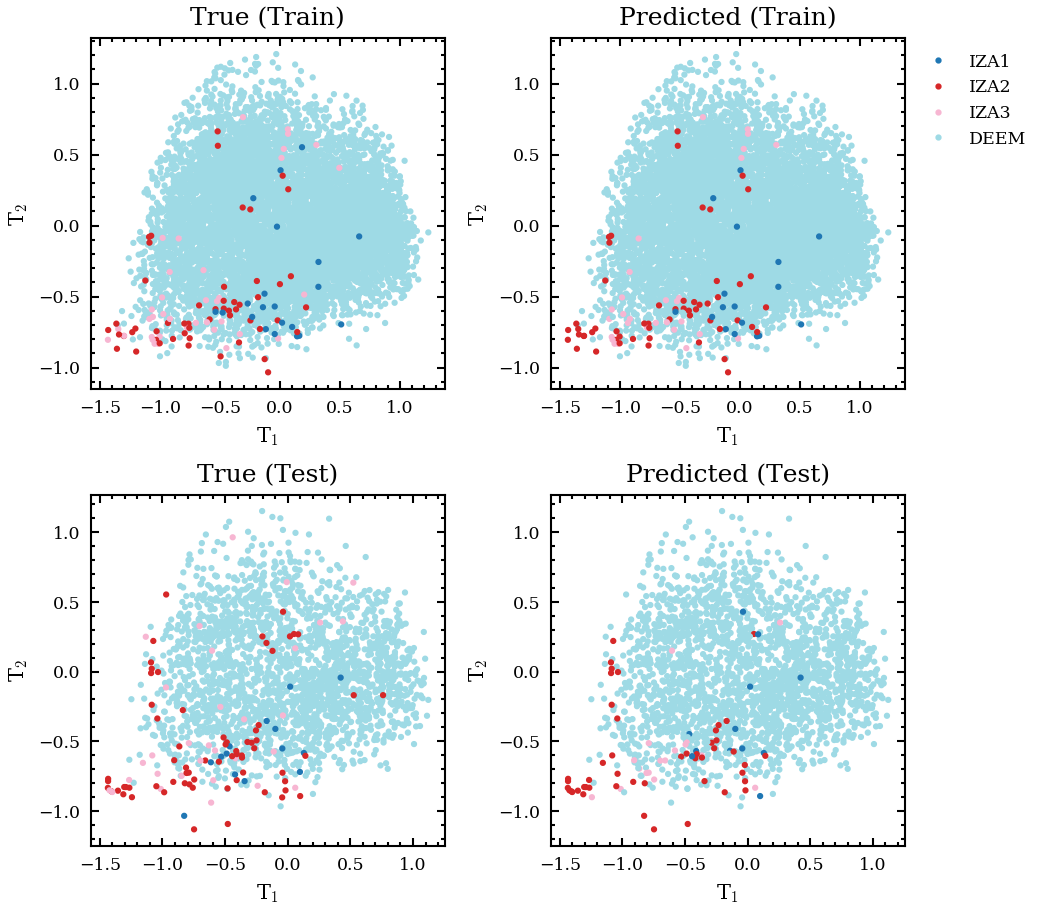

In [83]:
for cutoff in cutoffs:
    
    # Load projections
    deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/kpcovr_structures.hdf5'
    T_deem = load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)
    
    iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/kpcovr_structures.hdf5'
    T_iza = load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)
    
    # Load predicted cantons
    deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/kpcovr_structure_cantons.dat'
    predicted_cantons_deem = np.loadtxt(deem_file, dtype=int)
    
    iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/kpcovr_structure_cantons.dat'
    predicted_cantons_iza = np.loadtxt(iza_file, dtype=int)
    
    fig = plt.figure(figsize=(7.0, 7.0))
    axs_true_train = fig.add_subplot(2, 2, 1)
    axs_predicted_train = fig.add_subplot(2, 2, 2)
    axs_true_test = fig.add_subplot(2, 2, 3)
    axs_predicted_test = fig.add_subplot(2, 2, 4)
    scatter_opts = dict(cmap='tab20', vmin=1, vmax=4)

    axs_true_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                c=cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
    axs_true_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                c=cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

    axs_predicted_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                c=predicted_cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
    axs_predicted_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                c=predicted_cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)
    
    axs_true_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
            c=cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
    axs_true_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
            c=cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)
    
    axs_predicted_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
            c=predicted_cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
    axs_predicted_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
            c=predicted_cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

    handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
               Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
               Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
               Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]

    labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
    axs_predicted_train.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

    for ax in (axs_true_train, axs_predicted_train, axs_true_test, axs_predicted_test):
        ax.set_xlabel(r'T$_1$')
        ax.set_ylabel(r'T$_2$')
        
    axs_true_train.set_title('True (Train)')
    axs_predicted_train.set_title('Predicted (Train)')
    axs_true_test.set_title('True (Test)')
    axs_predicted_test.set_title('Predicted (Test)')
    
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    #fig.savefig(f'../Results/{cutoff}/svm-kpcovr.png', bbox_inches='tight')

    plt.show()

In [87]:
# Which Deem are misclassified as IZA?
np.nonzero(predicted_cantons_deem != 4)[0]

array([1215, 3474, 8271, 9687])